In [5]:
import fastai.data.all as fai_data
import fastai.vision.all as fai_vision
import torch
import torchvision

In [122]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
path = fai_data.untar_data(fai_data.URLs.MNIST)
path

Path('/home/daynil/.fastai/data/mnist_png')

In [8]:
dls = fai_vision.DataBlock(
    blocks=(fai_vision.ImageBlock, fai_vision.MultiCategoryBlock),
    get_items=fai_vision.get_image_files,
    splitter=fai_vision.GrandparentSplitter('training', 'testing'),
    get_y=fai_vision.parent_label
).dataloaders(path)

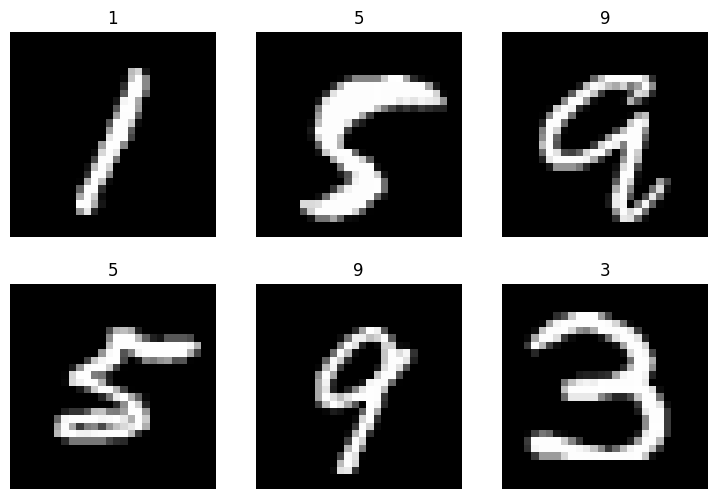

In [10]:
dls.show_batch(max_n=6)

In [139]:
images, labels = dls.train.one_batch()
# We have a batch of 64 images, with an RGB stack (3) of 28x28 pixels
images.shape

torch.Size([64, 3, 28, 28])

TensorMultiCategory(4, device='cuda:0')


<Axes: >

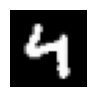

In [140]:
one_image = images[0]
print(labels[0].argmax())
one_image.show()

For the purposes of our pure python learner version, we want to compress the RGB image to grayscale, then combine all of the pixel rows into 1 row. This way, we can assign a weight to each pixel.

In [141]:
gray_image = torchvision.transforms.functional.rgb_to_grayscale(one_image)
gray_image_squeezed = gray_image.squeeze()
gray_image_squeezed_flattened = gray_image_squeezed.flatten()
one_image.shape, gray_image.shape, gray_image_squeezed.shape, gray_image_squeezed_flattened.shape

(torch.Size([3, 28, 28]),
 torch.Size([1, 28, 28]),
 torch.Size([28, 28]),
 torch.Size([784]))

In [142]:
# Pixels per dimension
px_per_dim = 28
images_tfmd = (
    torchvision.transforms.functional
        .rgb_to_grayscale(images).squeeze().view(64, px_per_dim**2)
)
images_tfmd.shape

torch.Size([64, 784])

In [168]:
torch.random.manual_seed(42)

To create a simple 1-layer neural network, we need to initialize the parameters in a particular way.

First, we need a weight for each pixel in the image, so 28*28 (784) weights, as well as a bias. This produces the parameters for a single neuron.

One neuron won't be enough to do anything useful, so we create this set of parameters for the amount of neurons we want, in this case, 100. Effectively, we get a set of 784 weights and 1 bias for each of the 100 neurons.

We represent this with tensors by creating a weights tensor and a bias tensor. The weights tensor is (pixels, hidden_neurons), and the bias is just hidden_neurons.

In [206]:
hidden_neurons = 100
# There are a total of 10 number classes (digits 0-9)
mnist_classes = 10

weights_layer_1 = torch.randn((px_per_dim**2, hidden_neurons), requires_grad=True, device=device)
bias_layer_1 = torch.randn(hidden_neurons, requires_grad=True, device=device)

weights_layer_2 = torch.randn((hidden_neurons, mnist_classes), requires_grad=True, device=device)
bias_layer_2 = torch.randn(mnist_classes, requires_grad=True, device=device)

Breaking down each of the model's forward pass, we have:

First linear layer:
Matrix multiply a batch of images by its weights and add the biases:
$$y = wx + b$$

This gives us a single output, y, for each neuron, so we have **100 total outputs per image**.

It's hard to associate this linear equation properly *per image* because matrix multiplication involves two "layers" of data - a `batch` of `batch_size` images as well as a set of weights of length `px` (pixels per image). If we apply the equation above to a single image, we get:

$$y = w_{px}x_{px} + b$$

This means we're matrix multiplying each individual pixel in the image by a weight for that image, then adding a bias.

However, in practice, we never use a single data item in our matrix multiplication because the GPU needs to have enough data to process for it to be efficient. This is where the bit that is tricky to visualize comes in:

TODO:
- (refine this - is it wrong? which is "batch" and which is "num_neurons"?)
- Add some images of the simples FCC network that I have in my obsidian per-step with matrix multiplication at each step visualized (for a simplified e.g. 4x4 pixel image).

$$y = w_{batch}x_{batch} + b_{batch}$$

Now, we're *simultaneously* getting $wb$ for pixels *of every image in the batch* in a single operation, then adding a . That's the beauty of matrix multiplication - this is done practically instantaneously on the GPU, and we get a single tensor of size (64, 100) as our final result for *the entire layer of 100 neurons and 64 images*. That is, 64 images in a batch, 100 outputs for each image, each output representing the $y$ in the linear equation.

In [205]:
preds = images_tfmd@weights_layer_1 + bias_layer_1
preds.shape

torch.Size([64, 100])

In [199]:
preds

TensorImage([[ 5.8395e-01,  7.7099e-01,  3.2095e-01,  ...,  1.6309e+01,
               1.5097e+01,  8.4860e+00],
             [-2.3377e+00, -5.4933e+00,  2.7442e+00,  ...,  1.1085e+01,
              -1.6795e+00, -7.7791e+00],
             [ 8.8088e+00, -4.0023e-02, -7.4369e+00,  ...,  1.4133e+01,
               1.4072e+00, -5.3275e+00],
             ...,
             [ 2.4089e+01, -1.4402e-02,  1.4289e+01,  ...,  4.3825e+00,
               2.3052e+00, -5.7478e+00],
             [ 1.2136e+01, -6.9187e-01,  1.0098e+01,  ...,  1.6278e+01,
               1.4465e+00,  4.1869e-01],
             [ 9.3971e+00, -2.5722e+00,  4.3713e+00,  ...,  2.8283e-01,
               5.3905e+00,  3.2354e+00]], device='cuda:0',
            grad_fn=<AliasBackward0>)

In [200]:
preds_relu = torch.nn.ReLU()(preds)

In [201]:
preds2 = preds_relu@weights_layer_2 + bias_layer_2

In [202]:
preds2.shape

torch.Size([64, 10])

In [203]:
final_preds = torch.nn.Softmax(dim=1)(preds2)

In [204]:
preds2[0], final_preds[0]

(TensorImage([  19.0906,   16.9825,  -91.3657,   11.6825,  -24.6830, -123.1642,
               160.3725,   42.3721,   80.2896,   19.8143], device='cuda:0',
             grad_fn=<AliasBackward0>),
 TensorImage([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
              0.0000e+00, 1.0000e+00, 0.0000e+00, 1.6614e-35, 0.0000e+00],
             device='cuda:0', grad_fn=<AliasBackward0>))